In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import our model from the .py file
from predator_prey_model import PredatorPreyChemostat

In [8]:
def run_stochastic_simulation(system, y0, t_end, dt, noise_level):
    """
    Runs a simulation using the Euler-Maruyama method to include stochasticity.
    """
    num_steps = int(t_end / dt)
    time = np.linspace(0, t_end, num_steps + 1)
    
    # Initialize array to store results
    results = np.zeros((len(y0), num_steps + 1))
    results[:, 0] = y0
    
    for i in range(num_steps):
        current_state = results[:, i]
        
        # 1. Calculate the deterministic step (what the system "wants" to do)
        derivatives = np.array(system._model_equations(time[i], current_state))
        deterministic_change = derivatives * dt
        
        # 2. Calculate the stochastic step (a random "kick")
        # We scale the noise by the population size and sqrt(dt)
        random_kick = np.random.normal(0, 1, len(y0)) * noise_level * current_state * np.sqrt(dt)
        
        # 3. Update the state and ensure non-negativity
        new_state = current_state + deterministic_change + random_kick
        results[:, i+1] = np.maximum(0, new_state) # Prevent populations from going negative
        
    return {
        'time': time, 'N': results[0], 'Chlorella': results[1],
        'Reproducing_Brachionus': results[2], 'Total_Brachionus': results[3]
    }

Running Stochastic Sims:   0%|          | 0/5 [00:00<?, ?it/s]

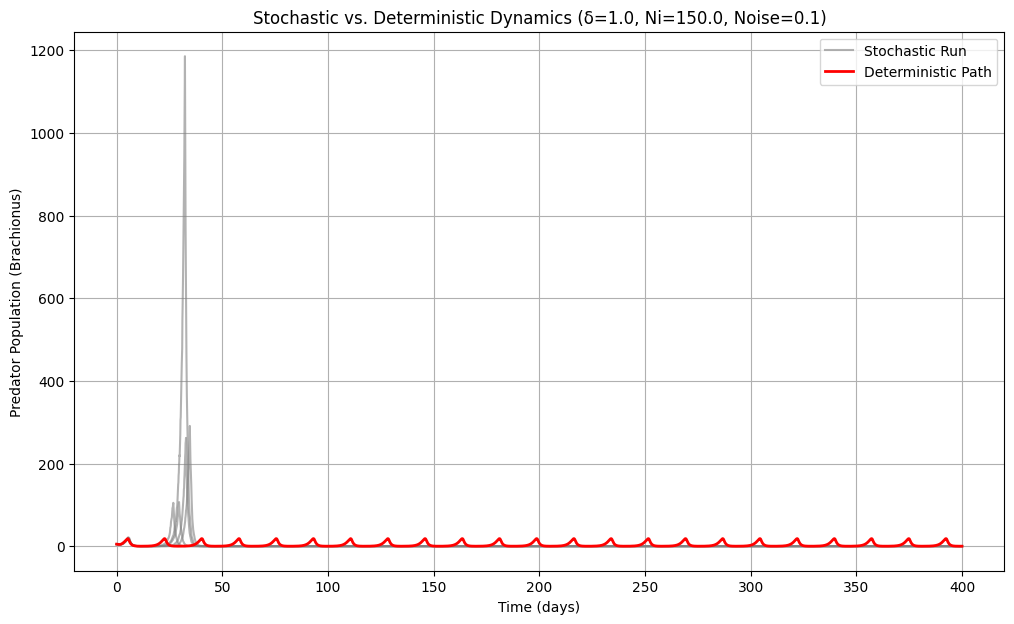

In [9]:
# --- Simulation Parameters ---
delta_val = 1.0
Ni_val = 150.0
noise_strength = 0.1 # Try values from 0.05 to 0.2
num_simulations = 5 # Run 5 different "possible futures"

# --- Time and Initial Conditions ---
t_simulation_end = 400
time_step = 0.1
initial_conditions = [60.0, 10.0, 5.0, 5.0]

# --- Run the simulations ---
stochastic_runs = []
system_params = PredatorPreyChemostat(delta=delta_val, Ni=Ni_val)
for _ in tqdm(range(num_simulations), desc="Running Stochastic Sims"):
    run = run_stochastic_simulation(system_params, initial_conditions, t_simulation_end, time_step, noise_strength)
    stochastic_runs.append(run)

# Also run one clean deterministic simulation for comparison
deterministic_run = PredatorPreyChemostat(delta=delta_val, Ni=Ni_val).run_simulation(
    initial_conditions, (0, t_simulation_end), np.arange(0, t_simulation_end, time_step)
)

# --- Plot the results ---
plt.figure(figsize=(12, 7))
plt.title(f'Stochastic vs. Deterministic Dynamics (δ={delta_val}, Ni={Ni_val}, Noise={noise_strength})')
plt.xlabel('Time (days)')
plt.ylabel('Predator Population (Brachionus)')

# Plot each stochastic run with low opacity
for i, run in enumerate(stochastic_runs):
    plt.plot(run['time'], run['Total_Brachionus'], color='gray', alpha=0.6, label=f'Stochastic Run' if i == 0 else "")

# Plot the clean deterministic run on top, in bold
plt.plot(deterministic_run['time'], deterministic_run['Total_Brachionus'], color='red', lw=2, label='Deterministic Path')

plt.legend()
plt.grid(True)
# plt.yscale('log')
# plt.ylim(bottom=0.01)
plt.show()